The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 全卷积网络
:label:`sec_fcn`

如 :numref:`sec_semantic_segmentation`中所介绍的那样，语义分割是对图像中的每个像素分类。
*全卷积网络*（fully convolutional network，FCN）采用卷积神经网络实现了从图像像素到像素类别的变换 :cite:`Long.Shelhamer.Darrell.2015`。
与我们之前在图像分类或目标检测部分介绍的卷积神经网络不同，全卷积网络将中间层特征图的高和宽变换回输入图像的尺寸：这是通过在 :numref:`sec_transposed_conv`中引入的*转置卷积*（transposed convolution）实现的。
因此，输出的类别预测与输入图像在像素级别上具有一一对应关系：通道维的输出即该位置对应像素的类别预测。


In [1]:
%matplotlib inline
import warnings
from d2l import paddle as d2l

warnings.filterwarnings("ignore")
import paddle
import paddle.vision as paddlevision
from paddle import nn
from paddle.nn import functional as F

## 构造模型

下面我们了解一下全卷积网络模型最基本的设计。
如 :numref:`fig_fcn`所示，全卷积网络先使用卷积神经网络抽取图像特征，然后通过$1\times 1$卷积层将通道数变换为类别个数，最后在 :numref:`sec_transposed_conv`中通过转置卷积层将特征图的高和宽变换为输入图像的尺寸。
因此，模型输出与输入图像的高和宽相同，且最终输出通道包含了该空间位置像素的类别预测。

![全卷积网络](http://d2l.ai/_images/fcn.svg)
:label:`fig_fcn`

下面，我们[**使用在ImageNet数据集上预训练的ResNet-18模型来提取图像特征**]，并将该网络记为`pretrained_net`。
ResNet-18模型的最后几层包括全局平均汇聚层和全连接层，然而全卷积网络中不需要它们。


In [2]:
pretrained_net = paddlevision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

W0818 09:21:31.243886 91274 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.8, Runtime API Version: 11.8
W0818 09:21:31.275069 91274 gpu_resources.cc:91] device: 0, cuDNN Version: 8.7.


0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.0%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.1%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.3%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.4%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.5%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.6%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.8%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

0.9%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.0%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.1%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.3%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.4%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.5%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.6%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.8%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

1.9%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.0%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.1%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.3%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.4%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.5%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.6%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.8%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

2.9%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.0%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.1%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.3%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.4%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.5%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.6%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.8%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

3.9%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.0%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.1%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.3%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.4%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.5%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.6%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.8%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

4.9%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.0%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.1%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.3%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.4%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.5%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.6%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.8%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

5.9%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.0%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.1%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.3%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.4%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.5%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.7%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.8%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

6.9%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.0%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.2%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.3%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.4%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.5%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.7%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.8%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

7.9%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.0%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.2%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.3%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.4%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.5%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.7%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.8%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

8.9%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.0%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.2%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.3%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.4%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.5%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.7%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.8%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

9.9%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.0%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.2%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.3%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.4%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.5%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.7%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.8%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

10.9%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.0%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.2%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.3%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.4%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.5%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.7%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.8%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

11.9%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.0%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.2%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.3%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.4%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.6%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.7%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.8%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

12.9%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.1%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.2%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.3%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.4%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.6%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.7%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.8%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

13.9%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.1%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.2%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.3%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.4%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.6%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.7%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.8%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

14.9%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.1%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.2%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.3%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.4%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.6%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.7%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.8%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

15.9%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.1%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.2%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.3%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.4%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.6%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.7%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.8%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

16.9%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.1%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.2%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.3%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.4%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.6%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.7%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.8%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

17.9%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.1%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.2%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.3%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.4%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.6%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.7%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.8%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.0%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.1%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.2%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.3%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.5%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.6%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.7%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.8%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.0%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.1%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.2%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.3%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.5%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.6%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.7%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.8%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.0%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.1%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.2%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.3%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.5%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.6%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.7%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.8%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.0%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.1%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.2%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.3%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.5%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.6%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.7%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.8%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.0%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.1%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.2%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.3%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.5%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.6%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.7%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.8%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.0%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.1%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.2%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.3%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.5%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.6%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.7%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.8%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.0%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.1%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.2%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.4%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.5%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.6%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.7%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

25.9%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.0%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.1%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.2%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.4%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.5%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.6%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.7%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

26.9%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.0%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.1%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.2%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.4%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.5%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.6%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.7%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

27.9%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.0%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.1%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.2%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.4%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.5%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.6%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.7%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

28.9%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.0%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.1%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.2%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.4%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.5%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.6%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.7%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

29.9%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.0%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.1%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.2%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.4%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.5%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.6%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.7%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

30.9%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.0%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.1%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.2%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.4%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.5%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.6%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.8%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

31.9%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.0%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.1%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.3%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.4%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.5%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.6%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.8%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

32.9%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.0%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.1%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.3%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.4%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.5%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.6%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.8%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

33.9%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.0%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.1%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.3%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.4%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.5%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.6%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.8%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

34.9%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.0%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.1%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.3%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.4%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.5%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.6%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.8%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

35.9%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.0%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.1%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.3%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.4%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.5%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.6%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.8%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

36.9%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.0%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.1%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.3%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.4%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.5%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.7%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.8%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

37.9%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.0%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.2%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.3%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.4%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.5%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.7%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.8%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

38.9%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.0%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.2%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.3%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.4%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.5%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.7%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.8%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

39.9%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.0%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.2%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.3%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.4%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.5%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.7%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.8%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

40.9%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.0%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.2%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.3%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.4%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.5%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.7%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.8%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

41.9%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.0%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.2%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.3%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.4%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.5%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.7%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.8%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

42.9%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.0%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.2%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.3%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.4%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.5%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.7%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.8%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

43.9%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.1%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.2%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.3%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.4%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.6%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.7%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.8%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

44.9%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.1%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.2%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.3%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.4%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.6%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.7%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.8%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

45.9%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.1%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.2%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.3%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.4%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.6%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.7%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.8%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

46.9%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.1%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.2%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.3%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.4%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.6%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.7%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.8%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

47.9%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.1%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.2%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.3%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.4%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.6%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.7%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.8%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

48.9%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.1%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.2%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.3%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.4%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.6%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.7%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.8%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

49.9%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.1%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.2%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.3%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.5%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.6%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.7%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.8%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.0%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.1%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.2%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.3%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.5%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.6%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.7%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.8%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.0%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.1%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.2%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.3%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.5%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.6%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.7%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.8%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.0%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.1%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.2%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.3%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.5%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.6%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.7%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.8%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.0%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.1%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.2%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.3%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.5%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.6%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.7%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.8%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.0%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.1%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.2%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.3%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.5%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.6%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.7%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.8%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.0%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.1%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.2%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.3%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.5%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.6%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.7%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

56.9%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.0%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.1%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.2%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.4%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.5%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.6%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.7%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

57.9%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.0%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.1%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.2%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.4%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.5%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.6%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.7%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

58.9%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.0%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.1%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.2%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.4%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.5%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.6%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.7%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

59.9%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.0%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.1%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.2%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.4%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.5%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.6%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.7%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

60.9%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.0%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.1%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.2%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.4%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.5%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.6%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.7%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

61.9%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.0%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.1%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.2%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.4%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.5%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.6%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.8%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

62.9%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.0%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.1%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.3%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.4%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.5%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.6%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.8%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

63.9%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.0%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.1%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.3%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.4%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.5%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.6%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.8%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

64.9%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.0%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.1%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.3%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.4%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.5%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.6%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.8%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

65.9%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.0%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.1%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.3%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.4%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.5%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.6%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.8%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

66.9%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.0%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.1%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.3%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.4%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.5%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.6%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.8%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

67.9%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.0%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.1%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.3%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.4%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.5%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.6%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.8%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

68.9%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.0%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.2%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.3%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.4%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.5%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.7%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.8%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

69.9%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.0%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.2%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.3%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.4%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.5%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.7%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.8%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

70.9%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.0%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.2%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.3%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.4%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.5%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.7%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.8%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

71.9%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.0%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.2%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.3%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.4%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.5%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.7%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.8%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

72.9%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.0%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.2%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.3%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.4%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.5%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.7%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.8%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

73.9%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.0%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.2%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.3%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.4%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.5%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.7%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.8%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

74.9%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.0%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.2%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.3%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.4%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.6%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.7%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.8%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

75.9%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.1%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.2%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.3%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.4%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.6%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.7%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.8%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

76.9%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.1%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.2%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.3%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.4%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.6%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.7%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.8%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

77.9%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.1%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.2%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.3%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.4%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.6%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.7%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.8%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

78.9%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.1%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.2%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.3%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.4%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.6%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.7%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.8%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

79.9%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.1%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.2%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.3%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.4%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.6%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.7%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.8%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

80.9%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.1%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.2%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.3%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.4%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.6%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.7%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.8%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.0%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.1%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.2%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.3%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.5%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.6%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.7%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.8%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.0%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.1%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.2%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.3%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.5%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.6%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.7%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.8%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.0%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.1%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.2%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.3%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.5%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.6%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.7%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.8%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.0%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.1%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.2%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.3%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.5%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.6%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.7%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.8%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.0%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.1%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.2%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.3%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.5%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.6%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.7%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.8%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.0%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.1%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.2%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.3%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.5%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.6%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.7%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

87.9%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.0%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.1%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.2%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.4%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.5%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.6%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.7%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

88.9%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.0%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.1%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.2%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.4%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.5%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.6%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.7%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

89.9%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.0%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.1%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.2%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.4%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.5%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.6%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.7%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

90.9%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.0%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.1%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.2%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.4%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.5%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.6%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.7%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

91.9%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.0%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.1%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.2%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

接下来，我们[**创建一个全卷积网络`net`**]。
它复制了ResNet-18中大部分的预训练层，除了最后的全局平均汇聚层和最接近输出的全连接层。


In [3]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])

给定高度为320和宽度为480的输入，`net`的前向传播将输入的高和宽减小至原来的$1/32$，即10和15。


In [4]:
X = paddle.rand(shape=(1, 3, 320, 480))
net(X).shape

[1, 512, 10, 15]

接下来[**使用$1\times1$卷积层将输出通道数转换为Pascal VOC2012数据集的类数（21类）。**]
最后需要(**将特征图的高度和宽度增加32倍**)，从而将其变回输入图像的高和宽。
回想一下 :numref:`sec_padding`中卷积层输出形状的计算方法：
由于$(320-64+16\times2+32)/32=10$且$(480-64+16\times2+32)/32=15$，我们构造一个步幅为$32$的转置卷积层，并将卷积核的高和宽设为$64$，填充为$16$。
我们可以看到如果步幅为$s$，填充为$s/2$（假设$s/2$是整数）且卷积核的高和宽为$2s$，转置卷积核会将输入的高和宽分别放大$s$倍。


In [5]:
num_classes = 21
net.add_sublayer('final_conv', nn.Conv2D(512, num_classes, kernel_size=1))
net.add_sublayer('transpose_conv', nn.Conv2DTranspose(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

Conv2DTranspose(21, 21, kernel_size=[64, 64], stride=[32, 32], padding=16, data_format=NCHW)

## [**初始化转置卷积层**]

在图像处理中，我们有时需要将图像放大，即*上采样*（upsampling）。
*双线性插值*（bilinear interpolation）
是常用的上采样方法之一，它也经常用于初始化转置卷积层。

为了解释双线性插值，假设给定输入图像，我们想要计算上采样输出图像上的每个像素。

1. 将输出图像的坐标$(x,y)$映射到输入图像的坐标$(x',y')$上。
例如，根据输入与输出的尺寸之比来映射。
请注意，映射后的$x′$和$y′$是实数。
2. 在输入图像上找到离坐标$(x',y')$最近的4个像素。
3. 输出图像在坐标$(x,y)$上的像素依据输入图像上这4个像素及其与$(x',y')$的相对距离来计算。

双线性插值的上采样可以通过转置卷积层实现，内核由以下`bilinear_kernel`函数构造。
限于篇幅，我们只给出`bilinear_kernel`函数的实现，不讨论算法的原理。


In [6]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (paddle.arange(kernel_size).reshape([-1, 1]),
          paddle.arange(kernel_size).reshape([1, -1]))
    filt = (1 - paddle.abs(og[0] - center) / factor) * \
           (1 - paddle.abs(og[1] - center) / factor)
    weight = paddle.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

让我们用[**双线性插值的上采样实验**]它由转置卷积层实现。
我们构造一个将输入的高和宽放大2倍的转置卷积层，并将其卷积核用`bilinear_kernel`函数初始化。


In [7]:
conv_trans = nn.Conv2DTranspose(3, 3, kernel_size=4, padding=1, stride=2,
                                bias_attr=False)
conv_trans.weight.set_value(bilinear_kernel(3, 3, 4));

读取图像`X`，将上采样的结果记作`Y`。为了打印图像，我们需要调整通道维的位置。


In [8]:
img = paddlevision.transforms.ToTensor()(d2l.Image.open('../img/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].transpose([1, 2, 0]).detach()

可以看到，转置卷积层将图像的高和宽分别放大了2倍。
除了坐标刻度不同，双线性插值放大的图像和在 :numref:`sec_bbox`中打印出的原图看上去没什么两样。


input image shape: [561, 728, 3]
output image shape: [1122, 1456, 3]


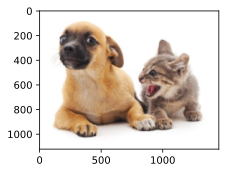

In [9]:
d2l.set_figsize()
print('input image shape:', img.transpose([1, 2, 0]).shape)
d2l.plt.imshow(img.transpose([1, 2, 0]));
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

全卷积网络[**用双线性插值的上采样初始化转置卷积层。对于$1\times 1$卷积层，我们使用Xavier初始化参数。**]


In [10]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.set_value(W);

## [**读取数据集**]

我们用 :numref:`sec_semantic_segmentation`中介绍的语义分割读取数据集。
指定随机裁剪的输出图像的形状为$320\times 480$：高和宽都可以被$32$整除。


In [11]:
import os


def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集
    Defined in :numref:`sec_semantic_segmentation`"""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    train_iter = paddle.io.DataLoader(
        d2l.VOCSegDataset(True, crop_size, voc_dir), batch_size=batch_size,
        shuffle=True, return_list=True, drop_last=True, num_workers=0)
    test_iter = paddle.io.DataLoader(
        d2l.VOCSegDataset(False, crop_size, voc_dir), batch_size=batch_size,
        drop_last=True, return_list=True, num_workers=0)
    return train_iter, test_iter

batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = load_data_voc(batch_size, crop_size)

read 1114 examples


read 1078 examples


## [**训练**]

现在我们可以训练全卷积网络了。
这里的损失函数和准确率计算与图像分类中的并没有本质上的不同，因为我们使用转置卷积层的通道来预测像素的类别，所以需要在损失计算中指定通道维。
此外，模型基于每个像素的预测类别是否正确来计算准确率。


loss 0.370, train acc 0.882, test acc 0.841
210.8 examples/sec on [Place(gpu:0)]


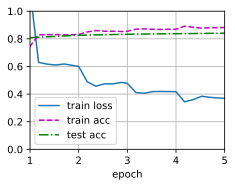

In [12]:
def loss(inputs, targets):
    return F.cross_entropy(inputs.transpose([0, 2, 3, 1]), targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = paddle.optimizer.SGD(learning_rate=lr, parameters=net.parameters(), weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices[:1])

## [**预测**]

在预测时，我们需要将输入图像在各个通道做标准化，并转成卷积神经网络所需要的四维输入格式。


In [13]:
def predict(img):
    X = paddle.to_tensor(test_iter.dataset.normalize_image(img),dtype='float32').unsqueeze(0)
    pred = net(X).argmax(axis=1)
    return pred.reshape([pred.shape[1], pred.shape[2]])

为了[**可视化预测的类别**]给每个像素，我们将预测类别映射回它们在数据集中的标注颜色。


In [14]:
def label2image(pred):
    colormap = paddle.to_tensor(d2l.VOC_COLORMAP)
    X = pred.astype(paddle.int32)
    return colormap[X]

测试数据集中的图像大小和形状各异。
由于模型使用了步幅为32的转置卷积层，因此当输入图像的高或宽无法被32整除时，转置卷积层输出的高或宽会与输入图像的尺寸有偏差。
为了解决这个问题，我们可以在图像中截取多块高和宽为32的整数倍的矩形区域，并分别对这些区域中的像素做前向传播。
请注意，这些区域的并集需要完整覆盖输入图像。
当一个像素被多个区域所覆盖时，它在不同区域前向传播中转置卷积层输出的平均值可以作为`softmax`运算的输入，从而预测类别。

为简单起见，我们只读取几张较大的测试图像，并从图像的左上角开始截取形状为$320\times480$的区域用于预测。
对于这些测试图像，我们逐一打印它们截取的区域，再打印预测结果，最后打印标注的类别。


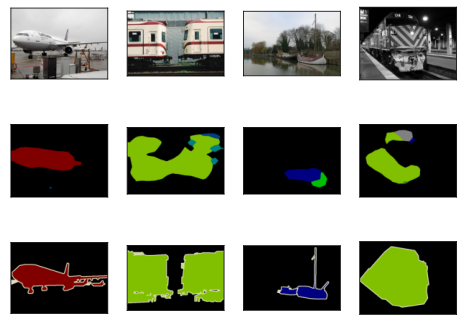

In [15]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = paddlevision.transforms.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.transpose([1,2,0]).astype('uint8'), pred,
             paddlevision.transforms.crop(
                 test_labels[i], *crop_rect).transpose([1, 2, 0]).astype("uint8")]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

## 小结

* 全卷积网络先使用卷积神经网络抽取图像特征，然后通过$1\times 1$卷积层将通道数变换为类别个数，最后通过转置卷积层将特征图的高和宽变换为输入图像的尺寸。
* 在全卷积网络中，我们可以将转置卷积层初始化为双线性插值的上采样。

## 练习

1. 如果将转置卷积层改用Xavier随机初始化，结果有什么变化？
1. 调节超参数，能进一步提升模型的精度吗？
1. 预测测试图像中所有像素的类别。
1. 最初的全卷积网络的论文中 :cite:`Long.Shelhamer.Darrell.2015`还使用了某些卷积神经网络中间层的输出。试着实现这个想法。


[Discussions](https://discuss.d2l.ai/t/11811)
